In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
random_forest_db = pd.read_csv('df_with_transformed_time.csv', index_col=False)

In [3]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)

In [4]:
X = random_forest_db.values[:, [1,2,3,4,5,6,7,8,9,10]]
Y = random_forest_db.values[:, 0]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 1)

In [6]:
clf = classifier.fit(X_train, y_train)

In [7]:
predictions = clf.predict(X_test)

In [8]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

       green       0.81      0.95      0.88   1097315
         red       0.73      0.47      0.57    287511
      yellow       0.58      0.24      0.34    146841

    accuracy                           0.79   1531667
   macro avg       0.71      0.55      0.60   1531667
weighted avg       0.77      0.79      0.77   1531667



In [9]:
X1 = random_forest_db.values[:, [1,2,3,4,5,6,7,9,10]]
Y1 = random_forest_db.values[:, 0]

In [10]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, random_state = 1)

In [11]:
clf1 = classifier.fit(X1_train, y1_train)

In [12]:
predictions1 = clf1.predict(X1_test)

In [13]:
print(metrics.classification_report(y1_test, predictions1))

              precision    recall  f1-score   support

       green       0.84      0.93      0.88   1097315
         red       0.70      0.56      0.62    287511
      yellow       0.45      0.27      0.34    146841

    accuracy                           0.80   1531667
   macro avg       0.66      0.59      0.61   1531667
weighted avg       0.78      0.80      0.78   1531667



In [14]:
balanced_df = random_forest_db.groupby('landing_safety')
balanced_df = random_forest_db.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

In [15]:
X2 = balanced_df.values[:, [1,2,3,4,5,6,7,9,10]]
Y2 = balanced_df.values[:, 0]

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, random_state = 1)

In [17]:
clf2 = classifier.fit(X2_train, y2_train)

In [18]:
predictions2 = clf2.predict(X2_test)

In [19]:
print(metrics.classification_report(y2_test, predictions2))

              precision    recall  f1-score   support

       green       0.72      0.97      0.82    105462
         red       0.19      0.03      0.05     27691
      yellow       0.11      0.01      0.01     14188

    accuracy                           0.70    147341
   macro avg       0.34      0.33      0.29    147341
weighted avg       0.56      0.70      0.60    147341



In [20]:
from sklearn.model_selection import cross_val_score

In [23]:
import numpy as np

In [24]:
def run_cross_validation_on_forest(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        forest_model = RandomForestClassifier(max_depth=depth)
        cv_scores = cross_val_score(forest_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(forest_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [25]:
sm_tree_depths = range(5,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X1_train, y1_train, sm_tree_depths)

In [26]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset for random forest'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-14 tree achieves the best mean cross-validation accuracy 74.84047 +/- 0.02136% on training dataset for random forest


In [27]:
clf3 = RandomForestClassifier(sm_best_tree_depth).fit(X1_train, y1_train)

In [28]:
predictions3 = clf3.predict(X1_test)

In [29]:
print(metrics.classification_report(y1_test, predictions3))

              precision    recall  f1-score   support

       green       0.84      0.93      0.88   1097315
         red       0.71      0.58      0.63    287511
      yellow       0.45      0.27      0.34    146841

    accuracy                           0.80   1531667
   macro avg       0.67      0.59      0.62   1531667
weighted avg       0.78      0.80      0.79   1531667



In [34]:
import matplotlib.pyplot as plt

In [35]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

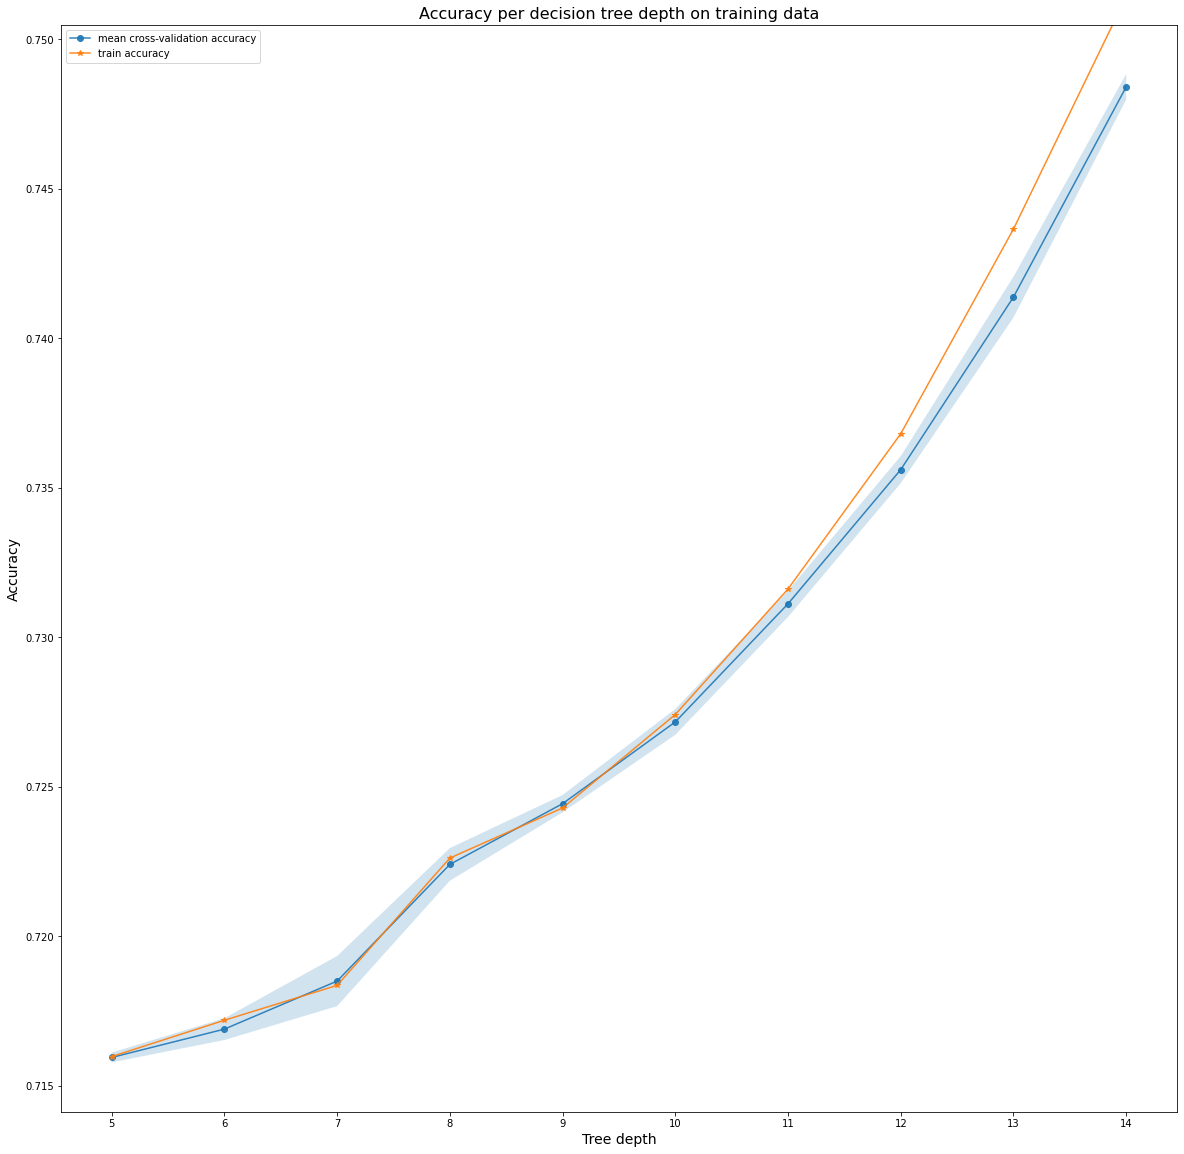

In [36]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [37]:
sm_tree_depths = range(15,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest(X1_train, y1_train, sm_tree_depths)

In [38]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset for random forest'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-24 tree achieves the best mean cross-validation accuracy 81.38278 +/- 0.0223% on training dataset for random forest


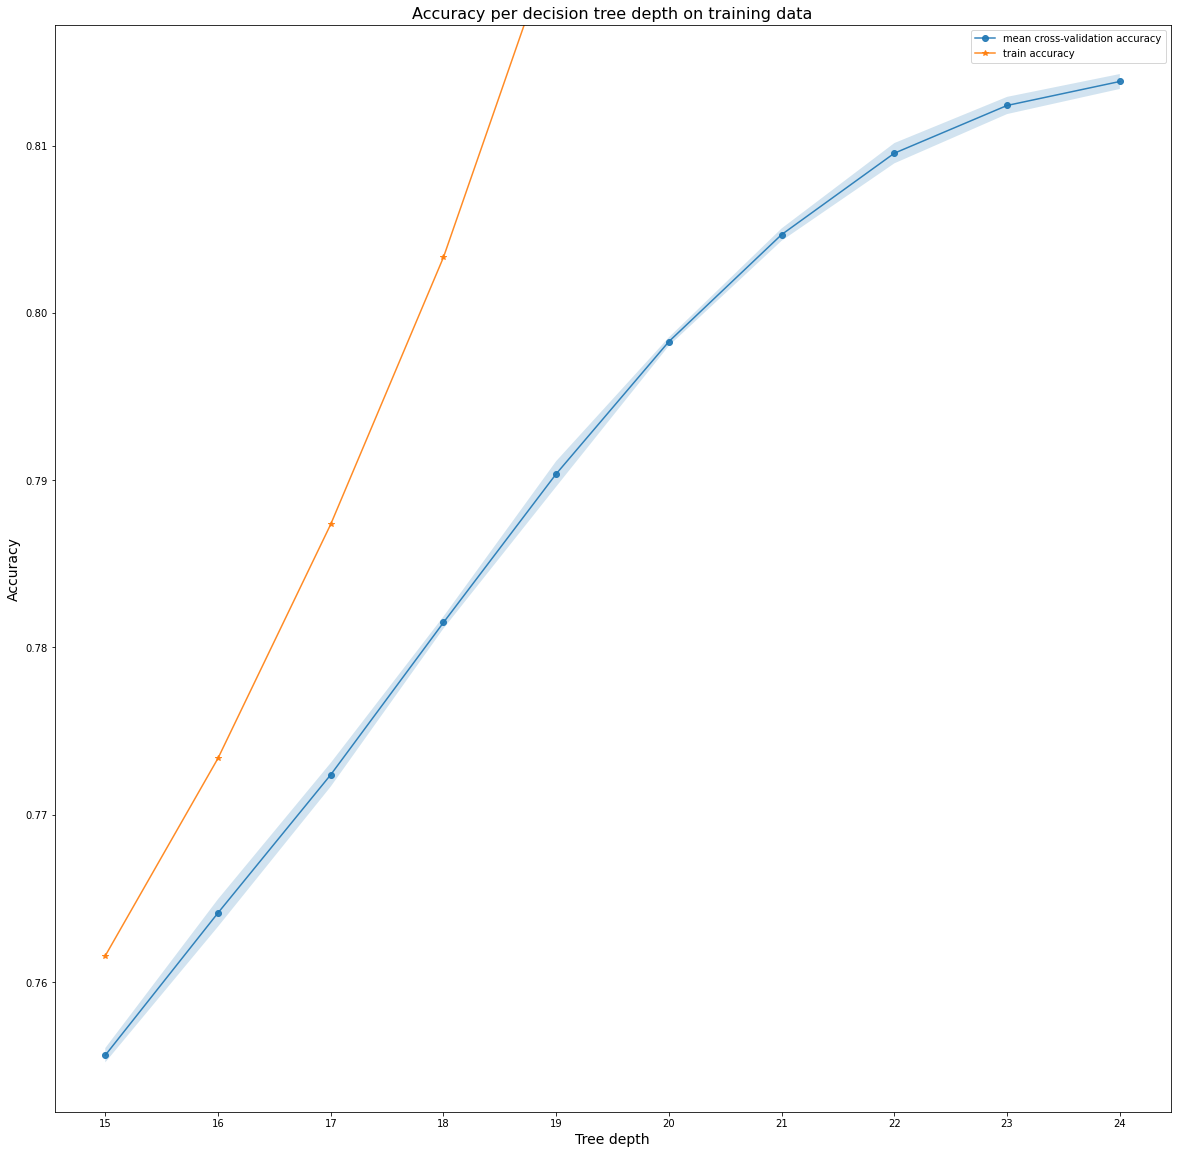

In [39]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [40]:
clf4 = RandomForestClassifier(sm_best_tree_depth).fit(X1_train, y1_train)

In [41]:
predictions4 = clf4.predict(X1_test)

In [42]:
print(metrics.classification_report(y1_test, predictions4))

              precision    recall  f1-score   support

       green       0.85      0.93      0.89   1097315
         red       0.71      0.59      0.64    287511
      yellow       0.46      0.28      0.34    146841

    accuracy                           0.80   1531667
   macro avg       0.67      0.60      0.62   1531667
weighted avg       0.78      0.80      0.79   1531667



In [43]:
clf5 = RandomForestClassifier(25).fit(X1_train, y1_train)

In [44]:
predictions5 = clf5.predict(X1_test)

In [45]:
print(metrics.classification_report(y1_test, predictions5))

              precision    recall  f1-score   support

       green       0.85      0.93      0.89   1097315
         red       0.71      0.59      0.64    287511
      yellow       0.46      0.28      0.35    146841

    accuracy                           0.80   1531667
   macro avg       0.67      0.60      0.63   1531667
weighted avg       0.78      0.80      0.79   1531667

